<a href="https://colab.research.google.com/github/ErtanOz/30DaysMapChallenge2024/blob/main/measuring_walkability_with_osm_and_isochrone_maps_city_cologne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install Library osmnx

!pip install osmnx


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 38.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1


Number of intersections:  97685
Number of road segments: 265346


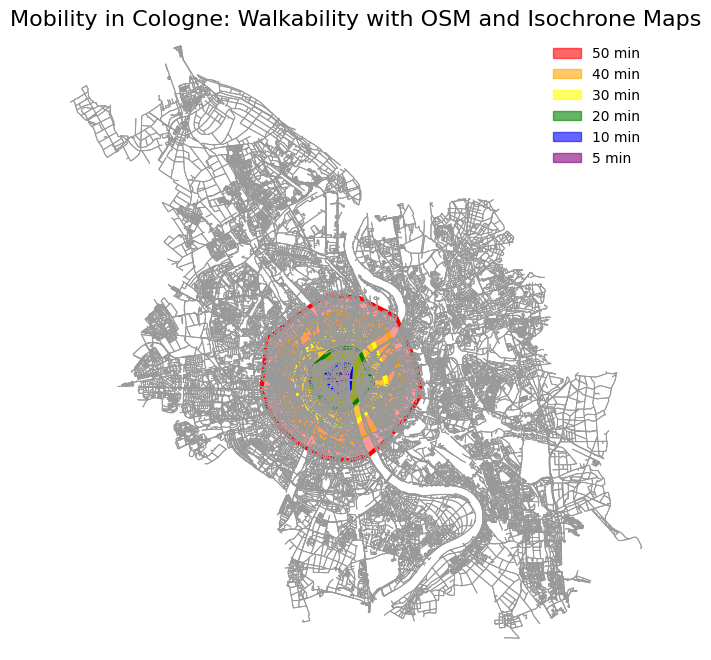

In [ ]:
import osmnx as ox
import networkx as nx
from shapely.geometry import Point, Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define the polygon for Cologne (Köln)
admin_district = ox.geocode_to_gdf('Cologne, Germany')
admin_poly = admin_district.geometry.values[0]

# Load the graph from OSMnx (for walkable routes)
G = ox.graph_from_polygon(admin_poly, network_type='walk')

print('Number of intersections: ', G.number_of_nodes())
print('Number of road segments:',  G.number_of_edges())

# Define the walking speed (5 km/h -> 1.39 m/s)
walking_speed = 1.39  # in meters per second

# Calculate travel time for each edge
for u, v, data in G.edges(data=True):
    data['travel_time'] = data['length'] / walking_speed

# Use Cologne Hauptbahnhof as the center node (geocoded)
center_point = (50.9422, 6.9577)  # Coordinates for Cologne Hauptbahnhof
center_node = ox.distance.nearest_nodes(G, X=center_point[1], Y=center_point[0])

# Define the isochrone times (in minutes)
isochrone_times = [5, 10, 20, 30, 40, 50]

# Generate isochrones
isochrone_polys = []
for time in isochrone_times:
    subgraph = nx.ego_graph(G, center_node, radius=time*60, distance='travel_time')

    # Create a convex hull polygon around the nodes within this subgraph
    node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
    polygon = Polygon(gpd.GeoSeries(node_points).unary_union.convex_hull)
    isochrone_polys.append(gpd.GeoSeries([polygon]))

# Plotting
fig, ax = plt.subplots(figsize=(8, 8))
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']

# Plot the isochrones
for idx, (polygon, time) in enumerate(reversed(list(zip(isochrone_polys, isochrone_times)))):
    polygon.plot(ax=ax, color=colors[idx], alpha=0.4, label=f'{time} min')
    polygon.plot(ax=ax, color='none', edgecolor=colors[idx], linewidth=3)

# Manually create legend handles
handles = [mpatches.Patch(color=colors[idx], alpha=0.6, label=f'{time} min') for idx, time in enumerate(reversed(isochrone_times))]

# Plot the network
ox.plot_graph(G, ax=ax, node_size=0, edge_linewidth=0.7, show=False)

# Add the legend to the plot and set the title
ax.set_title('Mobility in Cologne: Walkability with OSM and Isochrone Maps', fontsize=16)
legend = plt.legend(handles=handles)
legend.get_frame().set_linewidth(0)  # Remove the legend box's frame

# Show the plot
plt.show()
